In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [2]:
data = np.loadtxt('covtype.data', delimiter=',')
#data = np.loadtxt('covtype_7000.data', delimiter=',')

In [3]:
# Find the most common classes
count = Counter(data[:,54])
print(count.most_common(3))

[(2.0, 283301), (1.0, 211840), (3.0, 35754)]


In [4]:
for i in range(len(data[:,54])):
    if data[i,54] == 2:
        data[i,54] = 1
    else:
        data[i,54] = 0

In [5]:
print(data)
print(data.shape)

data_continuous = data[:,0:10]
d_s = StandardScaler()
d_n = d_s.fit_transform(data_continuous)

X_and_Y = np.hstack([d_n, data[:,10:56]])
print(X_and_Y)

[[  2.59600000e+03   5.10000000e+01   3.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.59000000e+03   5.60000000e+01   2.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.80400000e+03   1.39000000e+02   9.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 ..., 
 [  2.38600000e+03   1.59000000e+02   1.70000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.38400000e+03   1.70000000e+02   1.50000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.38300000e+03   1.65000000e+02   1.30000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
(581012, 55)
[[-1.29780509 -0.93515698 -1.48281978 ...,  0.          0.          0.        ]
 [-1.31923485 -0.89047967 -1.61636259 ...,  0.          0.          0.        ]
 [-0.5549068  -0.14883628 -0.68156292 ...,  0.          0.          1.        ]
 ..., 
 [-2.04784663  0.02987297  0.38677957 ...,  0.          0.  

In [6]:
# Divide data into training and testing sets

np.random.shuffle(X_and_Y)

# Try to predict the last column (the cover type, which is 7 types)
# NOTE: the largest number is "positive", while the other ones count as negative. This way it is a binary classification problem
X = X_and_Y[:5000,0:-1]
Y = X_and_Y[:5000,-1]
print(X.shape, Y.shape)

(5000, 54) (5000,)


In [7]:
X_train_val = X[:int(0.5*len(X))]
X_test      = X[int(0.5*len(X)):]
Y_train_val = Y[:int(0.5*len(Y))]
Y_test      = Y[int(0.5*len(Y)):]
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(2500, 54) (2500, 54) (2500,) (2500,)


In [17]:
# SVM process

# linear
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='linear')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]   
params = {"C": C_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([  0.34298344,   0.41178989,   0.32703071,   0.32142682,
          0.2966104 ,   0.28960671,   0.26821947,   0.36664047,
          1.29862499,   6.86918712,  61.43436427]),
 'mean_score_time': array([ 0.07255344,  0.07725439,  0.06644716,  0.06564593,  0.06316352,
         0.05824513,  0.04423423,  0.03782659,  0.03692312,  0.03532538,
         0.03652601]),
 'mean_test_score': array([ 0.5112,  0.5112,  0.5112,  0.5112,  0.6116,  0.7124,  0.7444,
         0.7664,  0.7668,  0.768 ,  0.7672]),
 'mean_train_score': array([ 0.5112    ,  0.5112    ,  0.5112    ,  0.5112    ,  0.61529817,
         0.71860264,  0.7578981 ,  0.77830156,  0.77760131,  0.77760126,
         0.77770136]),
 'param_C': masked_array(data = [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1.0 10.0 100.0 1000.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1e-07},
  {'C': 1e-06},
  {'C': 1e-05},
  {'C': 0.0001},
  {

In [18]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 100.0}
0.7504


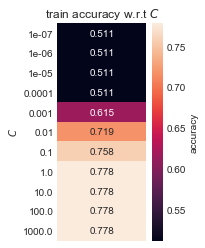

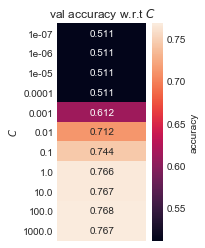

In [19]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
results = GSR.cv_results_

train_acc = np.matrix(results.get("mean_train_score")).T
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = np.matrix(results.get("mean_test_score")).T
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [10]:
def convert_to_gamma(radial_width):
    converted = [0]*len(radial_width)
    for i in range(len(radial_width)):
        gamma = 1/(2*(radial_width[i]**2))
        converted[i] = gamma
    return converted

radial_width = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
gamma_list = convert_to_gamma(radial_width)

# SVM process

# rbf
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='rbf')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]
params = {"C": C_list, "gamma": gamma_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([ 0.58471084,  0.60064321,  0.60877275,  0.61150107,  0.94196687,
         0.50638604,  0.44585032,  0.44860187,  0.58276582,  0.61094937,
         0.57963681,  0.60571156,  0.98635864,  0.53418961,  0.44406066,
         0.43872738,  0.55690255,  0.54739137,  0.61434841,  0.553794  ,
         0.9698854 ,  0.50075855,  0.42640114,  0.43000402,  0.52718287,
         0.54078736,  0.5382802 ,  0.56433954,  0.95950232,  0.49807372,
         0.42921247,  0.42179832,  0.55149035,  0.54928141,  0.56042671,
         0.55869417,  0.94677315,  0.49305873,  0.41830249,  0.42039881,
         0.56180363,  0.54699984,  0.55609632,  0.5751214 ,  0.98979917,
         0.51276212,  0.43230557,  0.42469964,  0.5481976 ,  0.56980734,
         0.58863463,  0.58372784,  1.00250907,  0.5520535 ,  0.46703024,
         0.42940426,  0.62484188,  0.5830143 ,  0.59772701,  0.62033877,
         1.02923307,  0.59504228,  0.46253285,  0.31282458,  0.62554493,
         0.63856421,  0.61653519, 

In [11]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 1.0, 'gamma': 0.5}
0.7828


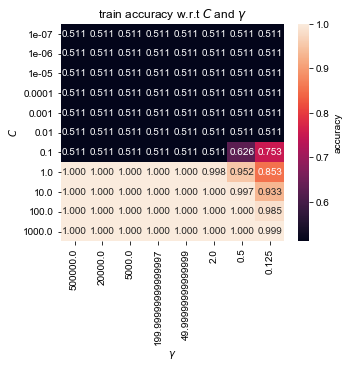

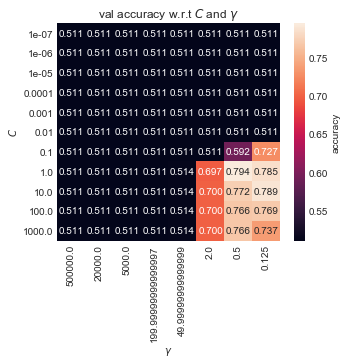

In [16]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()   

train_acc = GSR.cv_results_['mean_train_score'].reshape(11,8)
draw_heatmap_RBF(train_acc, 'train accuracy', gamma_list, C_list)

val_acc = GSR.cv_results_['mean_test_score'].reshape(11,8)
draw_heatmap_RBF(val_acc, 'val accuracy',gamma_list, C_list)

In [12]:
# KNN
k_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#k_list = [1,5,8]
params = {"n_neighbors": k_list}
knn = KNeighborsClassifier(n_neighbors=26)
kgs=GridSearchCV(knn, params)
knn.fit(X_train_val, Y_train_val)
knn.predict(X_test)

array([ 0.,  0.,  1., ...,  1.,  1.,  1.])

In [13]:
# compute accuracy
test_acc = np.sum(knn.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.7456


In [14]:
# Random Forest
rf = RandomForestClassifier(n_estimators=1024, random_state=0, n_jobs=4)
rf.fit(X_train_val, Y_train_val)
rf.predict(X_test)

array([ 0.,  0.,  1., ...,  1.,  1.,  0.])

In [15]:
# compute accuracy
test_acc = np.sum(rf.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.8052
